In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr, kendalltau
import seaborn as sb
from tqdm import tqdm

/var/folders/fl/wxh0fmxj54nfxl1pmyp76jv80000gn/T/ipykernel_24751/2237476770.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part 1 : Why do we need causality?
## "Correlation is not causation"
It is chanted by every statistician and their mothers, but why? Let's do some experiments.

### Experiment 0: Directionality
Let's say we have data on two variables, the expression of a certain gene and a disease status, and we want to see if they are correlated. Let's simulate some data assuming as ground truth that the gene is causal for the disease.

In [3]:
# simulate some data where expression causes disease
n = 100
expression = np.random.normal(0.5, 0.25, n)
disease = []

for i in range(n):
    # the causation is non-deterministic, 
    # low expression causes disease with 20% probability,
    # high expression with 80%
    if expression[i] <= 0.5:
        odds = 0.2
    else:
        odds = 0.8
    disease.append(
        np.random.choice(["Healthy", "Sick"], p = [1 - odds, odds])
    )

data = pd.DataFrame(
    {"Gene Expression": expression, "Disease State": disease}, 
    index = ["Patient {}".format(id) for id in range(1, n+1)]
    )
data.head()

,Gene Expression,Disease State
Patient 1,0.642037,Sick
Patient 2,0.476468,Healthy
Patient 3,0.464066,Healthy
Patient 4,0.286026,Healthy
Patient 5,0.526404,Sick


We can look at the correlation between the two variables, which is significant!

In [4]:
rho, p = spearmanr(expression, disease)
print("\tSpearman Rank correlation between expression and disease: \n\t{} (p = {})".format(rho, p))

	Spearman Rank correlation between expression and disease: 
	0.5001030004948989 (p = 1.1723488409388618e-07)


But quickly find out that correlation metrics are symmetric<sup>*</sup>, so we can't tell which variable would be causing the other.

In [5]:
rho, p = spearmanr(disease, expression)
print("\tSpearman Rank correlation disease-expression: \n\t{} (p = {})\n\n".format(rho, p))

rho, p = pearsonr([i == "Sick" for i in disease], expression)
print("\tPearson correlation expression-disease: \n\t{} (p = {})\n".format(rho, p))
rho, p = pearsonr(expression, [i == "Sick" for i in disease])
print("\tPearson correlation disease-expression: \n\t{} (p = {})\n\n".format(rho, p))

rho, p = kendalltau(disease, expression)
print("\tKendall's tau correlation expression-disease: \n\t{} (p = {})\n".format(rho, p))
rho, p = kendalltau(expression, disease)
print("\tKendall's tau correlation disease-expression: \n\t{} (p = {})".format(rho, p))

	Spearman Rank correlation disease-expression: 
	0.5001030004948989 (p = 1.1723488409388618e-07)


	Pearson correlation expression-disease: 
	0.4905040093030026 (p = 2.2131761403829968e-07)

	Pearson correlation disease-expression: 
	0.4905040093030026 (p = 2.2131761403829968e-07)


	Kendall's tau correlation expression-disease: 
	0.41036897317336335 (p = 6.492437491048515e-07)

	Kendall's tau correlation disease-expression: 
	0.41036897317336335 (p = 6.492437491048515e-07)


<sup>*</sup> Though obscure, there are some asymmetric correlation metrics, such as the $\xi$-correlation coefficient — as beautifully implemented in [this Julia package](https://github.com/stefftaelman/Xicor.jl).

### Experiment 1: The common cause
Not only directionality is left ambiguous, correlation can also spuriously link unrelated variables.

Let's suppose we that we also had data on the patient's age-group in the previous dataset.

In [6]:
# simulate some data
n = 100
ages = []
expression = []
disease = []

for i in range(n):
    age = np.random.choice(["Young", "Old"])
    ages.append(age)
    if age == "Young":
        odds = 0.2
        expression.append(np.random.normal(0.20, 0.25))
    else:
        odds = 0.8
        expression.append(np.random.normal(0.80, 0.25))
    #expression.append(np.random.choice(["Low", "High"], p = [1 - odds, odds]))
    disease.append(np.random.choice(["Healthy", "Sick"], p = [1 - odds, odds]))

data = pd.DataFrame(
    {"Gene Expression": expression, "Age": ages, "Disease State": disease}, 
    index = ["Patient {}".format(id) for id in range(1, n+1)]
    )
data.head()

,Gene Expression,Age,Disease State
Patient 1,0.603479,Old,Sick
Patient 2,0.643248,Old,Sick
Patient 3,0.319539,Young,Sick
Patient 4,1.259966,Old,Sick
Patient 5,0.826503,Old,Healthy


Let's take a look how the expression of this gene correlates with the disease state.

In [7]:
# calculate the spearman rank correlation
rho, p = spearmanr(data["Gene Expression"], data["Disease State"])
print("Spearman Rank correlation between expression and disease: \n{} (p = {}).".format(round(rho, 4), p))

Spearman Rank correlation between expression and disease: 
0.4258 (p = 1.0009133280911795e-05).


It appears we have a biomarker on our hands! 

Before we report back to the clinicians, however, let's take a look at how strongly this biomarker influences each age group.

In [8]:
# separate the age groups
young_people = [patient for patient in data.index if data.loc[patient, "Age"] == "Young"]
old_people = [patient for patient in data.index if data.loc[patient, "Age"] == "Old"]

# calculate some correlations
rho_young, p_young = spearmanr(data.loc[young_people, "Gene Expression"], data.loc[young_people, "Disease State"])
rho_old, p_old = spearmanr(data.loc[old_people, "Gene Expression"], data.loc[old_people, "Disease State"])

print("In the young age group, the gene and disease state have a correlation of {} (p = {})".format(round(rho_young, 4), p_young))
print("In the older age group, the gene and disease state have a correlation of {} (p = {})".format(round(rho_old, 4), p_old))

In the young age group, the gene and disease state have a correlation of 0.0069 (p = 0.9623772863265401)
In the older age group, the gene and disease state have a correlation of -0.1782 (p = 0.21087776671785066)


It appears our *"biomarker"* is not really of use for either young or old people... Now what's going on here?

While we're testing the effect expression $\xrightarrow{}$ disease state, it is in fact the age that is influencing both, *i.e.*, age is *confounding* the effect we're trying to test. Old people are more likely to have a higher expression of this gene, and are also more likely to have the disease. This is made apparent when we look at the effect adjusted for the age group, as we started to do above.

If we draw out the causal graph, it would look like this:

![Experiment-1-CG](figures/Exp1.png)

### Experiment 2: collider bias
While the common cause is quite widely understood, there's another less intuitive causal structure that can lead us to wrongful conclusions. 

Let's set up an experiment where we simultaneously flip two coins a number of times, but we only record the times when at least one of them shows heads, which should be most (75%) of the time.

In [12]:
results_coin_1 = []
results_coin_2 = []
n = 100

# we will just simulate a binary flip, where 1 = heads and 0 = tails
for i in range(n):
    coin_1 = np.random.choice([0, 1])
    coin_2 = np.random.choice([0, 1])
    if coin_1 or coin_2:
        results_coin_1.append(coin_1)
        results_coin_2.append(coin_2)

pd.DataFrame(
    {"coin 1": results_coin_1, "coin 2": results_coin_2}, 
    index=[f"flip nr. {i}" for i in range(1, len(results_coin_1)+1)]
    ).head()

,coin 1,coin 2
flip nr. 1,1,1
flip nr. 2,1,0
flip nr. 3,1,0
flip nr. 4,1,0
flip nr. 5,1,0


In [13]:
# calculate the spearman rank correlation between the coins
rho, p = spearmanr(results_coin_1, results_coin_2)

print("\t{} coin flips were recorded. The two coins are shown to be highly associated \n\t(Spearman Rank correlation = {}; p = {}). Further \n\tresearch is however required to uncover the exact nature of their relationship.".format(len(results_coin_1), round(rho, 4), p))

	74 coin flips were recorded. The two coins are shown to be highly associated 
	(Spearman Rank correlation = -0.4748; p = 1.918207205152694e-05). Further 
	research is however required to uncover the exact nature of their relationship.


Although the flipping of two coins should be two completely independent events, they are aparently extremely correlated when we don't have all the data.

To prove that this is not some kind of statistical fluke, let's repeat the experiment a 10000 times and plot a histogram of the p-values.

100%|██████████| 10000/10000 [00:09<00:00, 1031.90it/s]


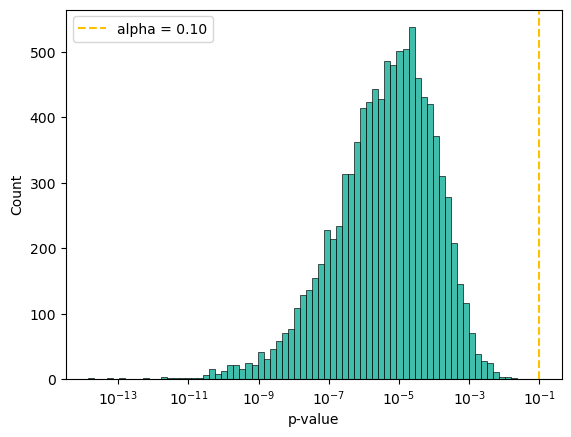

In [14]:
p_vals = []
for iteration in tqdm(range(10000)):
    results_coin_1 = []
    results_coin_2 = []
    n = 100

    # we will just simulate a binary flip, where 1 = heads and 0 = tails
    for i in range(n):
        coin_1 = np.random.choice([0, 1])
        coin_2 = np.random.choice([0, 1])
        if coin_1 or coin_2:
            results_coin_1.append(coin_1)
            results_coin_2.append(coin_2)

    # calculate the spearman rank correlation between the coins
    _, p = spearmanr(results_coin_1, results_coin_2)
    p_vals.append(p)

sb.histplot(p_vals, color="#00A98F", log_scale=True)
plt.axvline(0.1, color="#FFC000", linestyle="--", label="alpha = 0.10")
plt.xlabel('p-value')
plt.legend()
plt.savefig('collider_pvalue_hist.png', dpi=500)

In [17]:
print("{} runs had a non-significant p-value (alpha = 0.01)".format(sum([1 for i in p_vals if i > 0.01])))

6 runs had a non-significant p-value (alpha = 0.01)


Collider bias, also called selection bias, is still very prominent in research (e.g., [Griffith *et al.*, 2020](https://www.nature.com/articles/s41467-020-19478-2)), creating significant correlations where there should be none. An often cited example is the apparent negative correlation between actor's looks and their acting skills. If we only look at (*select*) successfull actors, we'll find some that have become popular by their looks and other by their acting prowess. Because only a smaller fraction will be both, we'll observe a negative correlation between the looks and acting skills in this group.